In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
sys.path.append("../")
import preproc as preproc
import train as train
import analysis as ana

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
# Same as Firnberg et al., 2014
AA_PROPERTY = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Aliphatic",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "G": "Aliphatic",
    "C": "Polar uncharged",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}

# Protein property features (alanine scanning feature is not included).
DEMASK_FEATURES = ['entropy', 'log2f_var', 'matrix']

# Data reading

In [3]:
# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms = pd.read_csv('../data/normalized/normalized_dms_DeMaSk_features.csv', 
                       index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/normalized_alanine_scanning.csv')

data_info = pd.read_csv('../data/data_info/dataset_info.csv', index_col=0)

# Modelling

In [4]:
def preproc_demask_dmsas_data(input_data):
    """Impute, encode and weight DMS+AS data.
    """
    preproc_data = input_data.copy()
    preproc_data = preproc.impute_missing_value(preproc_data, None, ['AS_score'])
    # Encode wild-type & variant type amino acid with AS scores.
    preproc_data, encoded_col = preproc.encode_categorical_feature(preproc_data, ['aa1', 'aa2'], ['aa1', 'aa2'])
    preproc_data[encoded_col] = preproc_data[encoded_col].mul(preproc_data['AS_score'], axis='index')
    # Weight each variant.
    preproc_data = train.add_training_weight(preproc_data)
    return preproc_data, encoded_col


def model_linear_predictor_lopo(input_data, output_dir, encoded_col):
    """Run leave-one-protein-out cross-validation on (filtered) DMS-AS data.
    """
    # LOPO CV
    for unip in input_data['uniprot_id'].unique():
        train_data = input_data.query("uniprot_id != @unip")
        test_data_ori = input_data.query("uniprot_id == @unip")
        train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)

        for model in ['with_as', 'no_as']:
            output_header = f"{output_dir}{unip}_{model}_"
            if model == 'with_as':
                model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
            else:
                model_features = DEMASK_FEATURES.copy()

            estimator = LinearRegression(n_jobs=1)
            predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
            test_data = test_data_ori.copy()
            test_data['pred_score'] = predictor.predict(test_data[model_features])
            test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
    return

## Model with all alanine scanning (AS) data

In [5]:
all_as = norm_as.copy()
# Merge in a cartesian product way.
dms_all_as = pd.merge(norm_dms, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()

In [6]:
dms_all_as, encoded_col = preproc_demask_dmsas_data(dms_all_as)
model_linear_predictor_lopo(dms_all_as, '../result/prediction/linear_as/all_as/', encoded_col)

## Model with assay compatibility filtered AS subset

### High compatible only

In [7]:
# Pick AS subset that are highly compatibility with given DMS assay.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_comp_as = pd.merge(norm_dms, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_comp_as['dmsa_id'] = dms_comp_as['dms_id'] + '@' + dms_comp_as['Ascan_id'].astype(str)
dms_comp_as['Ascan_score_avail'] = ~dms_comp_as['AS_score'].isna()

In [8]:
dms_comp_as, encoded_col = preproc_demask_dmsas_data(dms_comp_as)
model_linear_predictor_lopo(dms_comp_as, '../result/prediction/linear_as/compatible_as/', encoded_col)

### High and medium compatible

In [9]:
# Pick AS subset that are highly compatibility with given DMS assay.
hmcomp_as_id = data_info.query("assumed_compatibility in ['High', 'Medium']")[['dms_id', 'Ascan_id']]
hmcomp_as = pd.merge(norm_as, hmcomp_as_id, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_hmcomp_as = pd.merge(norm_dms, hmcomp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_hmcomp_as['dmsa_id'] = dms_hmcomp_as['dms_id'] + '@' + dms_hmcomp_as['Ascan_id'].astype(str)
dms_hmcomp_as['Ascan_score_avail'] = ~dms_hmcomp_as['AS_score'].isna()

In [10]:
dms_hmcomp_as, encoded_col = preproc_demask_dmsas_data(dms_hmcomp_as)
model_linear_predictor_lopo(dms_hmcomp_as, '../result/prediction/linear_as/high+med_as/', encoded_col)

## Model with score correlation filtered AS subset

In [11]:
# Pick AS data with highest regularized correlation for DMS study.
corr_as_id = []
for index, df in data_info.groupby('dms_id', as_index=False):
    df = df.dropna().sort_values(['regularized_correlation', 'n_ala', 'Ascan_id'])
    if len(df) > 0:
        corr_as_id.append(df.iloc[-1][['dms_id', 'Ascan_id']])  # Pick data with largest regularized correlation.
corr_as_id = pd.DataFrame(corr_as_id)
corr_as = pd.merge(norm_as, corr_as_id, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_corr_as = pd.merge(norm_dms, corr_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_corr_as['dmsa_id'] = dms_corr_as['dms_id'] + '@' + dms_corr_as['Ascan_id'].astype(str)
dms_corr_as['Ascan_score_avail'] = ~dms_corr_as['AS_score'].isna()

In [12]:
dms_corr_as, encoded_col = preproc_demask_dmsas_data(dms_corr_as)
model_linear_predictor_lopo(dms_corr_as, '../result/prediction/linear_as/correlate_as/', encoded_col)

# Performance

## Read results

In [13]:
def read_lopo_prediction_result(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_as', 'no_as']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_prediction.csv", index_col=0) 
                                    for unip in target_proteins])
    pred_merge = pd.merge(results['with_as'], results['no_as'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge

In [14]:
file_dir = {'All AS data': '../result/prediction/linear_as/all_as/',
            'Compatibility filtered': '../result/prediction/linear_as/compatible_as/',
            'Correlation filtered': '../result/prediction/linear_as/correlate_as/'}
target_proteins = norm_dms['uniprot_id'].unique()

# Read prediction results.
mut_prediction = dict()
for model in file_dir.keys():
    pred_merge = read_lopo_prediction_result(file_dir[model], target_proteins)
    mut_prediction[model] = pred_merge

In [15]:
# Evaluate performance with Spearman's ρ on each DMS-AS pair.
model_perform = []
for model in mut_prediction.keys():
    perf_with_as = ana.subgroup_spearmanr(mut_prediction[model], 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(mut_prediction[model], 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    model_perform.append(perf_merge)
model_perform = pd.concat(model_perform)

# Post process.
model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
model_perform['diff_spear'] = model_perform['With AS'] - model_perform['No AS']
model_perform = pd.merge(model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

In [16]:
if_one_residue = dms_all_as.groupby('dmsa_id')['u_pos'].nunique()
one_residue_filter = if_one_residue[if_one_residue == 1].index

## Models performance

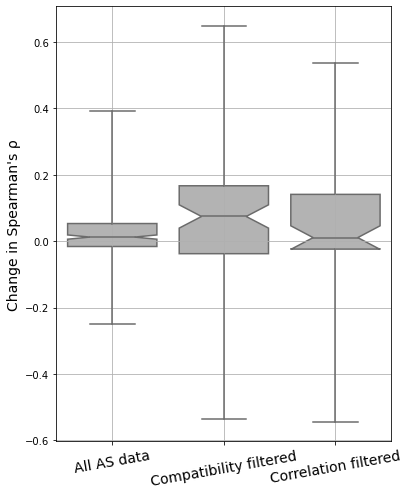

In [17]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=10)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

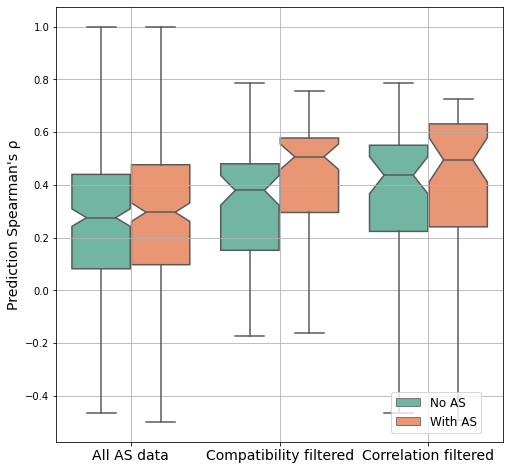

In [18]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                         var_name='Feature', value_name='spear')

fig, ax = plt.subplots(1,1,figsize=(8, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.75,0.02], fontsize=12)
ax.grid()
plt.show()

## Compatibility filtering details

### Individual DMS-AS pair

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


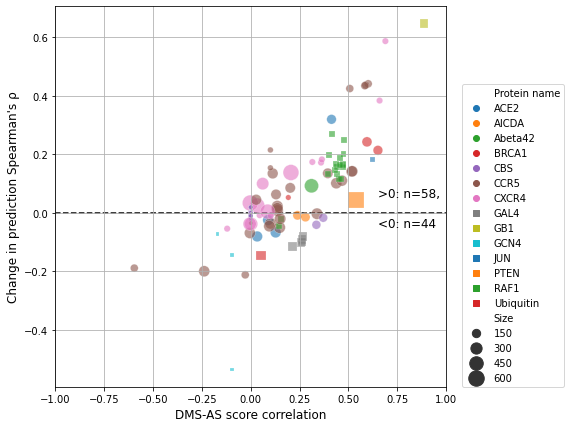

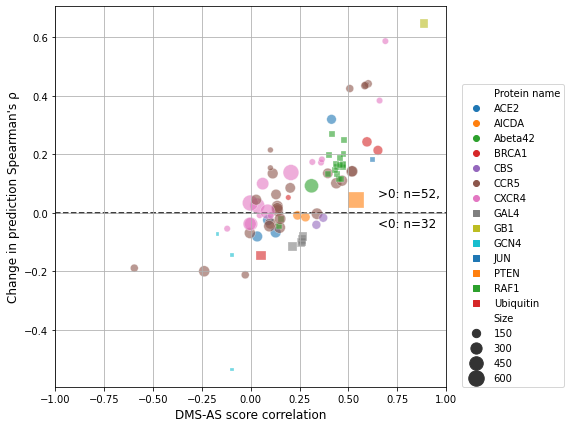

In [19]:
def foo_scatter(work_data):
    """Visualize performance change by using AS data against DMS-AS score correlation.
    """
    # Set markers.
    order = np.sort(work_data['Protein name'].unique())
    half = int(len(order)/2)
    markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    fig.patch.set_facecolor('w')
    g = sns.scatterplot(data=work_data, x='dmsa_corr', y='diff_spear', size='Size', hue='Protein name', 
                        hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                        palette="tab10", markers=markers)
    ax.hlines(0, *[-1, 1], linestyles='--', colors='k', zorder=0)  # Baseline.
    ax.text(0.65, -0.05, f">0: n={sum(work_data['diff_spear']>0)},\n\n<0: n={sum(work_data['diff_spear']<0)}", 
            fontsize=12)
    ax.set_xlabel('DMS-AS score correlation', fontsize=12)
    ax.set_ylabel('Change in prediction Spearman\'s ρ', fontsize=12)
    ax.set_xlim(-1, 1)
    ax.legend(loc=(1.04, 0))
    ax.grid()
    plt.show()

    
# Calculate DMS-AS score correlatioin.
dmsa_corr = pd.Series(name='dmsa_corr')
for dmsa, df in dms_all_as.groupby('dmsa_id'):
    # Remove variants data with no AS score available.
    if dmsa[-3:] == 'nan':
        continue
    else:
        dmsa_corr[dmsa] = spearmanr(df['score'], df['AS_score'])[0]
# NA value happens when all AS scores are the same, which are then imputed to 0.
dmsa_corr = dmsa_corr.fillna(0)

work_data = pd.merge(model_perform, dmsa_corr, how='inner', left_on='dmsa_id', right_index=True, 
                     validate='m:1')
work_data.rename(columns={'protein_name':'Protein name', 'size':'Size'}, inplace=True)
foo_scatter(work_data.query("model == 'Compatibility filtered'"))
foo_scatter(work_data.query("model == 'Compatibility filtered' & dmsa_id not in @one_residue_filter"),)

### Individual amino acid type

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


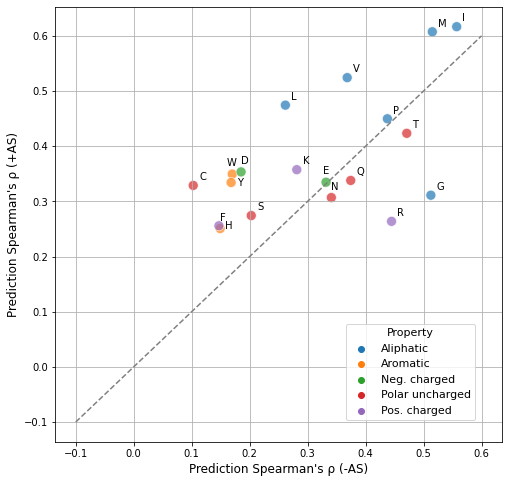

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


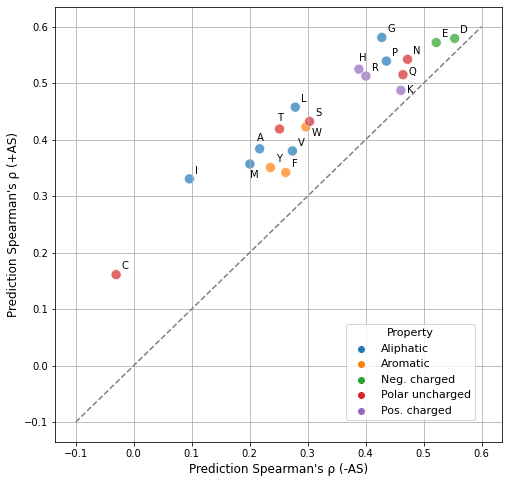

In [21]:
def foo_aa_type_spear(input_data, aa_type):
    """Calculate prediction correlation for each amino acid type.
    """
    # Remove data with no AS scores available.
    work_data = input_data[input_data['dmsa_id'].str[-4:] != '@nan']
    
    # Calculate prediction correlation.
    columns = ['pred_score_ala', 'pred_score_noala']
    foo = ana.subgroup_spearmanr(work_data, aa_type, 'score', 'pred_score_ala')[['rho']]
    foo.columns = ['pred_score_ala']
    bar = ana.subgroup_spearmanr(work_data, aa_type, 'score', 'pred_score_noala')[['rho']]
    bar.columns = ['pred_score_noala']
    aa_perf = pd.concat([foo, bar], axis=1)
    
    # Postprocess.
    aa_perf['aa'] = aa_perf.index
    aa_perf["Property"] = aa_perf["aa"].map(AA_PROPERTY)
    aa_perf['diff'] = aa_perf['pred_score_ala'] - aa_perf['pred_score_noala']
    return aa_perf.sort_values('Property')


def foo_scatter(vis_data, text_shift=dict()):
    """Visualize prediction performance for using AS data or not on each amino acid type.
    """
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.patch.set_facecolor('w')
    g = sns.scatterplot('pred_score_noala', 'pred_score_ala', data=vis_data, hue='Property', palette='tab10', 
                        s=100, alpha=0.7, ax=ax)
    ax.plot([-0.1,0.6],[-0.1,0.6], '--', color='gray')  # Baseline.
    # Amino acid labels.
    for index, row in vis_data.iterrows():
        aa = row['aa']
        x_shift = text_shift.get(aa,[0.01,0.01])[0]
        y_shift = text_shift.get(aa,[0.01,0.01])[1]
        ax.text(row['pred_score_noala']+x_shift, row['pred_score_ala']+y_shift, aa)
    ax.legend(loc=[.65,0.05], fontsize=11).set_title('Property', prop={'size': 11})
    ax.set_ylabel("Prediction Spearman's ρ (+AS)", fontsize=12)
    ax.set_xlabel("Prediction Spearman's ρ (-AS)", fontsize=12)
    ax.grid()
    plt.show()
    

# Adding wild-type amino acid info.
work_data = pd.merge(mut_prediction['Compatibility filtered'], dms_all_as[['dmsa_id', 'position', 'aa2', 'aa1']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], validate='m:1')
# Calculate prediction correlation for each amino acid type.
wt_perf = foo_aa_type_spear(work_data, 'aa1')
mt_perf = foo_aa_type_spear(work_data, 'aa2')
foo_scatter(wt_perf, {'E':[-0.005,0.015], 'N':[0,0.015], 'Y':[0.01,-0.005], 'H':[0.01,-0.005],
                      'F':[0,0.015], 'W':[-0.01,0.015], 'D':[0,0.015]})
foo_scatter(mt_perf, {'K':[0.01,-0.005], 'Q':[0.01,0], 'H':[0,0.015], 'W':[0.01,-0.015], 'M':[0,-0.025], 
                      'A':[-0.005,0.015], 'T':[-0.005,0.015]})

### ROC plot

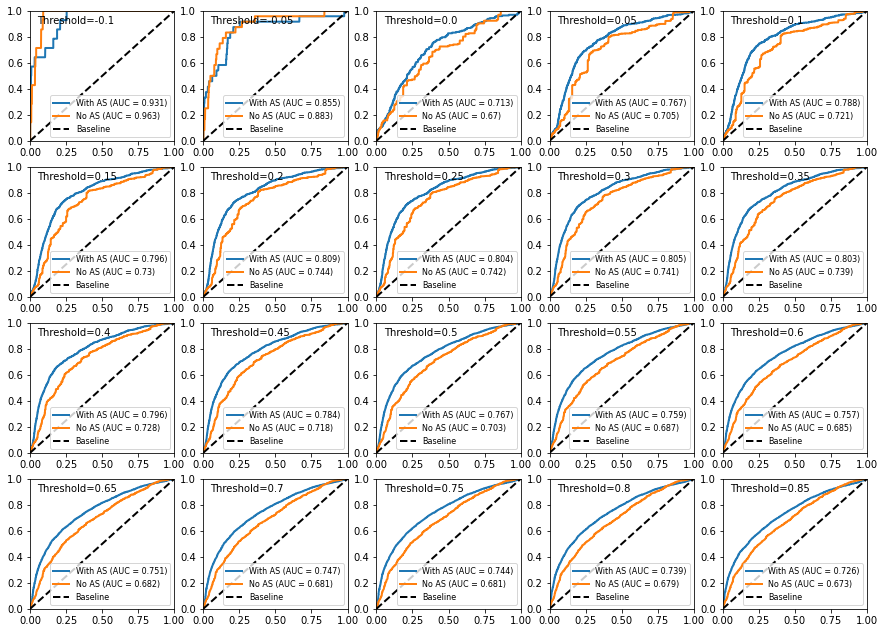

In [22]:
work_data = mut_prediction['Compatibility filtered'].copy()
work_data = work_data[work_data['dmsa_id'].str[-4:] != '@nan']

fig, axs = plt.subplots(4, 5, figsize=(15, 11))
fig.patch.set_facecolor('w')
axs = axs.reshape(-1)

label_map = {'pred_score_ala': 'With AS', 'pred_score_noala': 'No AS'}
for i, threshold in enumerate(np.arange(-0.1, 0.9, 0.05)):
    threshold = np.round(threshold, 2)
    if_loss = work_data['score'] <= threshold
    # Iterate over prediction results with and without AS data.
    for result in ['pred_score_ala', 'pred_score_noala']:
        score_loss = -work_data[result]
        ana.plot_roc_curve_on_axes(axs[i], label_map[result], if_loss, score_loss)
    axs[i].plot([0, 1], [0, 1], color="k", lw=2, linestyle="--", label="Baseline")
    axs[i].text(0.05, 0.9, f"Threshold={threshold}")
    axs[i].legend(loc="lower right", fontsize=8)
plt.show()

## Other results

### Performance on variants without (filtered) AS data

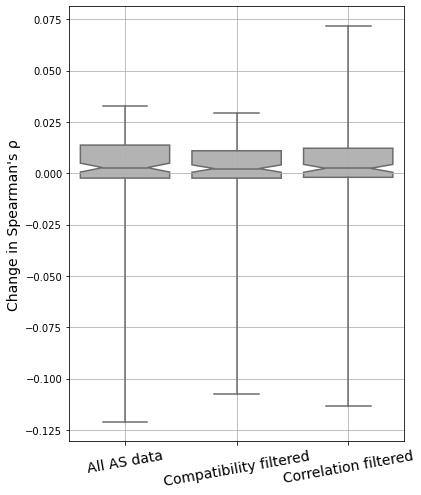

In [23]:
# Keep data with no AS score available.
vis_data = model_perform[model_perform['Ascan_id'].isna()]

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=10)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

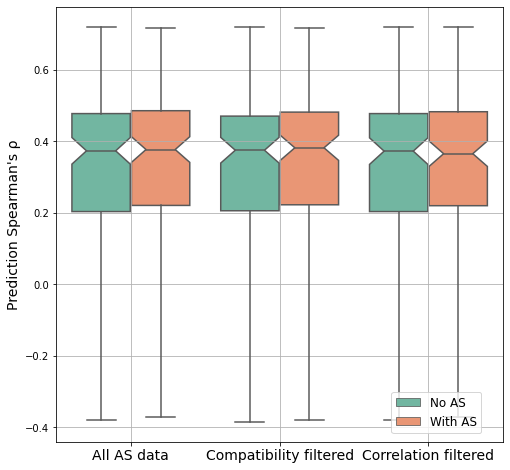

In [24]:
vis_data = model_perform[model_perform['Ascan_id'].isna()]
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                           var_name='Feature', value_name='spear')

fig, ax = plt.subplots(1,1,figsize=(8, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.75,0.02], fontsize=12)
ax.grid()
plt.show()

### High+medium compatibility performance

In [25]:
# Read and evaluate results.
hmcomp_prediction = read_lopo_prediction_result('../result/prediction/linear_as/high+med_as/', 
                                                norm_dms['uniprot_id'].unique())
hmcomp_perform = dict()
for pred_col in ['pred_score_ala', 'pred_score_noala']:
    hmcomp_perform[pred_col] = ana.subgroup_spearmanr(hmcomp_prediction, 'dmsa_id', 'score', pred_col)
hmcomp_perform = pd.merge(hmcomp_perform['pred_score_ala'], hmcomp_perform['pred_score_noala'][['rho']], 
                          left_index=True, right_index=True, validate="1:1", suffixes=["_ala", "_noala"], 
                          how='outer')
hmcomp_perform['model'] = 'High+medium\ncompatibility'

# Post process.
hmcomp_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
hmcomp_perform['diff_spear'] = hmcomp_perform['With AS'] - hmcomp_perform['No AS']
hmcomp_perform = pd.merge(hmcomp_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

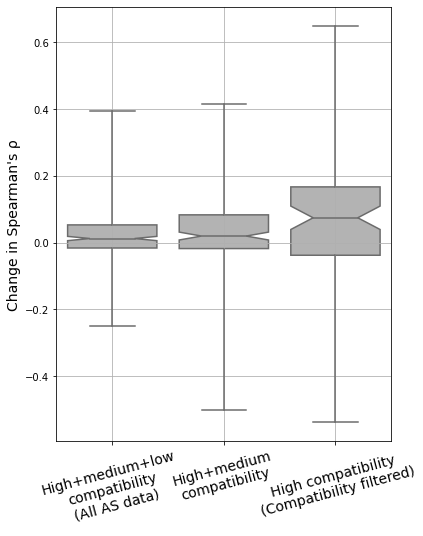

In [26]:
prev_results = model_perform.query("model in ['All AS data', 'Compatibility filtered']")
prev_results = prev_results.replace({'All AS data': 'High+medium+low\ncompatibility\n(All AS data)',
                                     'Compatibility filtered': 'High compatibility\n(Compatibility filtered)'})
vis_data = pd.concat([hmcomp_perform, prev_results])
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = vis_data[~vis_data['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf,
            order=['High+medium+low\ncompatibility\n(All AS data)', 'High+medium\ncompatibility', 
                   'High compatibility\n(Compatibility filtered)'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=15)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

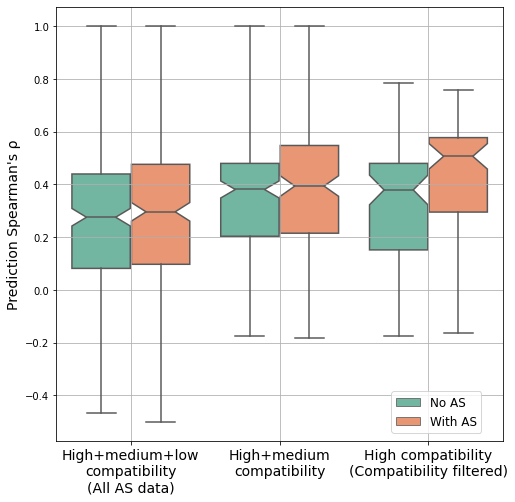

In [27]:
prev_results = model_perform.query("model in ['All AS data', 'Compatibility filtered']")
prev_results = prev_results.replace({'All AS data': 'High+medium+low\ncompatibility\n(All AS data)',
                                     'Compatibility filtered': 'High compatibility\n(Compatibility filtered)'})
vis_data = pd.concat([hmcomp_perform, prev_results])
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = vis_data[~vis_data['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                         var_name='Feature', value_name='spear')

fig, ax = plt.subplots(1,1,figsize=(8, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf,
            order=['High+medium+low\ncompatibility\n(All AS data)', 'High+medium\ncompatibility', 
                   'High compatibility\n(Compatibility filtered)'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.75,0.02], fontsize=12)
ax.grid()
plt.show()

### Detail of all AS data result

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


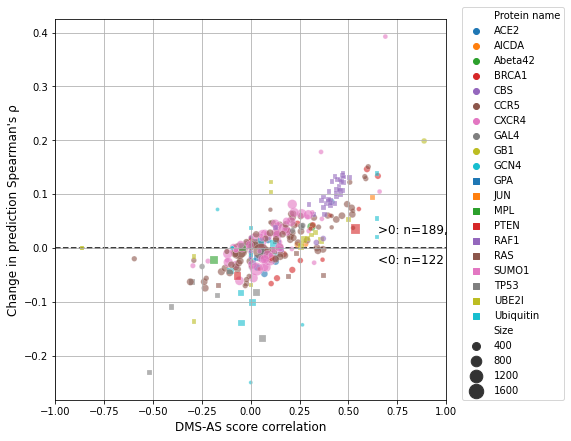

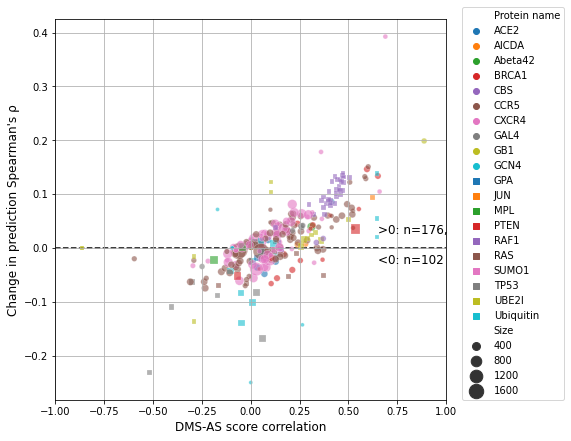

In [28]:
def foo_scatter(work_data):
    """Visualize performance change by using AS data against DMS-AS score correlation.
    """
    # Set markers.
    order = np.sort(work_data['Protein name'].unique())
    half = int(len(order)/2)
    markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    fig.patch.set_facecolor('w')
    g = sns.scatterplot(data=work_data, x='dmsa_corr', y='diff_spear', size='Size', hue='Protein name', 
                        hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                        palette="tab10", markers=markers)
    ax.hlines(0, *[-1, 1], linestyles='--', colors='k', zorder=0)  # Baseline.
    ax.text(0.65, -0.03, f">0: n={sum(work_data['diff_spear']>0)},\n\n<0: n={sum(work_data['diff_spear']<0)}", 
            fontsize=12)
    ax.set_xlabel('DMS-AS score correlation', fontsize=12)
    ax.set_ylabel('Change in prediction Spearman\'s ρ', fontsize=12)
    ax.set_xlim(-1, 1)
    ax.legend(loc=(1.04, 0))
    ax.grid()
    plt.show()

    
# Calculate DMS-AS score correlatioin.
dmsa_corr = pd.Series(name='dmsa_corr')
for dmsa, df in dms_all_as.groupby('dmsa_id'):
    # Remove variants data with no AS score available.
    if dmsa[-3:] == 'nan':
        continue
    else:
        dmsa_corr[dmsa] = spearmanr(df['score'], df['AS_score'])[0]
# NA value happens when all AS scores are the same, which are then imputed to 0.
dmsa_corr = dmsa_corr.fillna(0)

work_data = pd.merge(model_perform, dmsa_corr, how='inner', left_on='dmsa_id', right_index=True, 
                     validate='m:1')
work_data.rename(columns={'protein_name':'Protein name', 'size':'Size'}, inplace=True)
foo_scatter(work_data.query("model == 'All AS data'"))
foo_scatter(work_data.query("model == 'All AS data' & dmsa_id not in @one_residue_filter"),)